## Week 9-1: Gaussian process

_Bo Y.-C. Ning_

#### Last time
* B-splines

#### Today
* Gaussian process

#### Reference
* Ch 11 of GvdVNP
* Ray Bai @ USC's notes on GP
* Rasmussen and Williams (2006). Gaussian Processes for Machine Learning. [download here](http://gaussianprocess.org/gpml/chapters/RW.pdf)
* Python examples: https://peterroelants.github.io/posts/gaussian-process-tutorial/
* Visualization for GP: https://distill.pub/2019/visual-exploration-gaussian-processes/

### Nonparametric regression 

Consider the data $(X_1, Y_1), \dots, (X_n, Y_n)$ are i.i.d., and 
$$
Y_i = f(X_i) + \varepsilon_i, \quad \varepsilon_i \overset{i.i.d}{\sim} N(0, \sigma^2).
$$
In this lecture, we estimate $f$ using Gaussian process.

### Gaussian process

To understand what is a Gaussian process (GP), let's introduce _stochastic processes_ first: 

__Definition 1.__  A _stochastic process_ is a collection of random variables defined on a common probability space. 

We already seen the Dirchilet process (DP), which is a stochastic process whose finite measurable partition follows a Dirichlet distribution. Another example of a stochastic process is the Brownian motion, which describe the random motion of particles dispersed in a certain medium (e.g., a liquid).  

The Gaussian process is also a stochastic process. Similar to DP, its finite measurable function follows a multivariate Gaussian distribution. Below is the formal definition.

__Definition 2.__ A _Gaussian process_ $W$ is a stochastic process such that finite-dimensional distribution of $(W(t_1), \dots, W(t_m))$ are multivariate normally distribution for $t_1, \dots, t_m \in T$, $m \in \mathbb{N}^+$.


__Definition 3.__ A stochastic process is said _strongly stationary_ if $W((X_1, X_2, \dots, X_n))' = W((X_1 + h), (X_2 + h), \dots, (X_n + h))'$ have the same distribution for any $n \in \mathbb{N}$. A stochastic process is said 
_weakly stationary_ if it is mean stationary $m(X) = \mu$ for all $X \in \mathbb{X}$ and covariance-stationary $K(X, X+h) = K(0,h)$.

A Gaussian process $W(X)$ is strongly stationary if and only if it is weakly stationary.
The finite-dimensional distributions are specified by the mean function and covariance kernel given by 

$$
m(t) = \mathbb{E}[W(t)], \quad K(t, s) = \mathbb{E}(W(t), W(s)).
$$

Example of kernels:

- _White noise kernel_: $K(t, s) = \sigma^2 I_d$, $t, s \in \mathbb{R}^d$. The covariance is a diagonal matrix.

- _RBF kernel_: $K(t, s) = \sigma^2 \exp\big(-\frac{\|t - s\|^2}{2l^2} \big)$. The RBF kernel is the most widely used kernel in practice. RBF stands for radial basis function, which is a real-valued function whose value only depends on the distance between $t$ and $s$. Sometimes, this kernel is also called the squared exponential (SE) kernel. 

    - $\sigma^2$ the variance determines the average distance of your function away from its mean;
    - $l$ the length determines the length of the 'wiggles' of the kernel function
    
- _Ornstein-Uhlenbeck(OU) Kernel_: $K(t, s) = \sigma^2 \exp\big( - \frac{\|t - s\|}{l}\big)$. If one believe the function should not be too smooth, the OU kernel is used for produce fairly rough functions.

- _Periodic kernel_: $K(t, s) = \sigma^2 \exp\big(-\frac{2\sin^2(\pi\|t - s\|/p)}{l^2} \big)$.

    - $\sigma^2$ and $l$ the same as in RBF kernel;
    - $p$ the period determines the interval between two waves.
    
- _Linear kernel_: $K(t, s) = \sigma_b^2 + \sigma^2(t-c)'(s-c)$. The linear kernel is nonstaionary. Typically, if one knows that there should be an upward or downward trend in the sample function, the linear kernel can be added to a standard stationary kernel to produce a function that oscillates around a linear function.
    
    - $\sigma_b^2$ the height the function at zero;
    - $c$ is the offset. At the point $c$, the function has zero variance.
    
Other kernels: rational quadratic kernel, local periodic kernel, Matérn kernel ...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.simplefilter("ignore")

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels

sns.set_style('darkgrid')
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# from: https://peterroelants.github.io/posts/gaussian-process-kernels/

def plot_kernel(X, y, sigma, description, fig, subplot_spec, xlim,
                scatter=False, rotate_x_labels=False):
    """Plot kernel matrix and samples."""
    grid_spec = gridspec.GridSpecFromSubplotSpec(
        1, 2, width_ratios=[2,1], height_ratios=[1],
        wspace=0.18, hspace=0.0,
        subplot_spec=subplot_spec)
    ax1 = fig.add_subplot(grid_spec[0])
    ax2 = fig.add_subplot(grid_spec[1])
    # Plot samples
    if scatter:
        for i in range(y.shape[1]):
            ax1.scatter(X, y[:,i], alpha=0.8, s=3)
    else:
        for i in range(y.shape[1]):
            ax1.plot(X, y[:,i], alpha=0.8)
    ax1.set_ylabel('$y$', fontsize=13, labelpad=0)
    ax1.set_xlabel('$x$', fontsize=13, labelpad=0)
    ax1.set_xlim(xlim)
    if rotate_x_labels:
        for l in ax1.get_xticklabels():
            l.set_rotation(30)
    ax1.set_title(f'Samples from {description}')
    # Plot covariance matrix
    im = ax2.imshow(sigma, cmap=cm.YlGnBu)
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.02)
    cbar = plt.colorbar(im, ax=ax2, cax=cax)
    cbar.ax.set_ylabel('$K(X,X)$', fontsize=8)
    ax2.set_title(f'Covariance matrix\n{description}')
    ax2.set_xlabel('X', fontsize=10, labelpad=0)
    ax2.set_ylabel('X', fontsize=10, labelpad=0)
    # Show 5 custom ticks on x an y axis of covariance plot
    nb_ticks = 5
    ticks = list(range(xlim[0], xlim[1]+1))
    ticks_idx = np.rint(np.linspace(
        1, len(ticks), num=min(nb_ticks,len(ticks)))-1).astype(int)
    ticks = list(np.array(ticks)[ticks_idx])
    ax2.set_xticks(np.linspace(0, len(X), len(ticks)))
    ax2.set_yticks(np.linspace(0, len(X), len(ticks)))
    ax2.set_xticklabels(ticks)
    ax2.set_yticklabels(ticks)
    if rotate_x_labels:
        for l in ax2.get_xticklabels():
            l.set_rotation(30)
    ax2.grid(False)

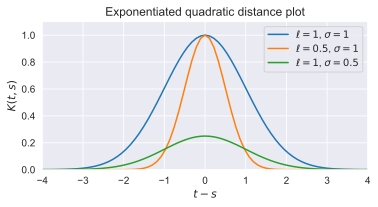

In [3]:
# Plot exponentiated quadratic distance

xlim = (-4, 4)
X = np.expand_dims(np.linspace(*xlim, num=75), 1)
zero = np.array([[0.]])
# Make the plots
fig, ax = plt.subplots(figsize=(5.4, 3))

S = tfk.ExponentiatedQuadratic(amplitude=1., length_scale=1.).matrix(zero, X).numpy()
ax.plot(X[:,0], S[0,:], label='$\\ell = 1$, $\\sigma = 1$')
S = tfk.ExponentiatedQuadratic(amplitude=1., length_scale=0.5).matrix(zero, X).numpy()
ax.plot(X[:,0], S[0,:], label='$\\ell = 0.5$, $\\sigma = 1$')
S = tfk.ExponentiatedQuadratic(amplitude=0.5, length_scale=1.).matrix(zero, X).numpy()

ax.plot(X[:,0], S[0,:], label='$\\ell = 1$, $\\sigma = 0.5$')
ax.set_xlabel('$t - s$', fontsize=11)
ax.set_ylabel('$K(t,s)$', fontsize=11)
ax.set_title('Exponentiated quadratic distance plot')
ax.set_ylim([0, 1.1])
ax.set_xlim(*xlim)
ax.legend(loc=1)
plt.tight_layout()
plt.show()

Other examples: [see here](https://peterroelants.github.io/posts/gaussian-process-kernels/)

### Nonparametric regression using Gaussian process priors

We have defined the Gaussian process, the speficiation of a kernel function $k(x, x')$ implies a distribution over functions. To see this, one can draw samples of distribution of functions evaluated at any number of points. For a input points $X = (x_1, \dots, x_n)$ and a given kernel, we can generate Gaussian vector $f = (f_1, \dots, f_n)'$ and $f_i = f(x_i)$ as 

$$
f = N(0, K_{X, X'}), 
$$

where $K_{X, X'} = k(x_i, x_j)$.

The following fact can be useful for deriving the prediction distribution. 

__Fact 1.__ (Conditional distribution for the multivariate normal) Suppose $Y \sim N(\mu, \Sigma)$ with partition $Y = (Y_1', Y_2')'$ and $\mu = (\mu_1', \mu_2')'$ and the covariance 

$$
\Sigma = 
\begin{pmatrix}
\Sigma_{1,1} & \Sigma_{1,2} \\
\Sigma_{2,1} & \Sigma_{2,2},
\end{pmatrix}
$$

then the conditional distribution $Y_1 | Y_2 = u \sim N(\tilde \mu, \tilde \Sigma)$, where 
$\tilde \mu = \mu_1 + \Sigma_{12} \Sigma_{22}^{-1} (u - \mu_2)$ and $\tilde \Sigma = \Sigma_{11} - \Sigma_{12} \Sigma_{22}^{-1} \Sigma_{21}$. 

Now return to the issue of prediction with GP, let's consider the _noise-free_ case, we have $Y_1, \dots, Y_n$ and $X_1, \dots, X_n$ and we want to make prediction at $X_1^\star, \dots, X_m^\star$. Assuming $f$ and $f^\star$ are generated from a zero mean Gaussian process, the joint distribution of $f$ and $f^\star$ is 

$$
\begin{pmatrix}
Y \\ f^\star
\end{pmatrix}
\sim 
N\Bigg[
\begin{pmatrix}
0_n \\ 0_m
\end{pmatrix},
\begin{pmatrix}
K_{X,X} & K_{X, X^\star} \\
K_{X^\star, X} & K_{X^\star, X^\star}.
\end{pmatrix}
\Bigg]
$$
Then you can derive $f^\star|Y$ based on the expression given in Fact 1.

When data has noise, the model is given by $y_i = f(X_i) + \varepsilon_i, \varepsilon_i \overset{iid}{\sim} N(0, \sigma^2)$. We have 
$$
\begin{pmatrix}
Y \\ f^\star
\end{pmatrix}
\sim 
N\Bigg[
\begin{pmatrix}
0_n \\ 0_m
\end{pmatrix},
\begin{pmatrix}
K_{X,X} + \sigma^2I_n & K_{X, X^\star} \\
K_{X^\star, X} & K_{X^\star, X^\star}
\end{pmatrix}
\Bigg].
$$
Then $f^\star | Y \sim N(\mu^\star, \Sigma^\star)$, where 
$$
\mu^\star = K_{X^\star, X} [K_{X,X} + \sigma^2 I_n]^{-1} Y
$$
and 
$$
\Sigma^\star = K_{X^\star, X^\star} - K_{X^\star, X}[K_{X,X} + \sigma^2 I_n]^{-1} K_{X, X^\star}.
$$

Then the point estimator is $\mu^\star$ and the two-sided $(1-\alpha)$% prediction interval is $[\mu_i^\star - z^\star \sqrt{\Sigma^\star_{ii}}, \mu_i^\star + z^\star \sqrt{\Sigma^\star_{ii}}]$, where $z^\star$ is the upper $\alpha/2$ critical value for the standard normal distribution.


A simple algorithm goes like this:

1. Input training data $\{(X_i, Y_i)\}_{i=1}^n$ and test data $\{X_i\}_{i=1}^m$; input $\hat \sigma^2$ and estimated values for hyperparameters;
2. Center  $\bar{Y} = \sum_{i=1}^n Y_i/n$ and standardize the training $\{X_i\}_{i=1}^n$ and the test $\{X_i\}_{i=1}^m$;
3. Use standardized traning and test data to construct the kernel;
4. Calculate $\mu^\star$ and $\Sigma^\star$
5. Set $\mu^\star \leftarrow \mu^\star + \bar Y \mathbb{1}_m$ as the estimated mean

#### Estimating hyperparameters 

So far, we have not discuss how to choose the hyperparameters. One possibility is to put priors on those hyperparameters. However, those priors are typically not conjugate, sampling from their posteriors can be challenging. Another approach is to use empirical Bayes. We estimate their values by maximizing the _marginal maximum likelihood_. 
The marginal likelihood of $y$ is 
$$
p(y) = \int p(y | f)p(f) df = N(0, K_{X, X} + \sigma^2 I_n).
$$

Depending which kernel we choose, the goal is to maximize $p(y)$ with respect to the hyperparameter in the kernel. Let's denote $C(\eta) = K_{X,X} + \sigma^2 I_n$, the negative log-marginal likelihood is given as 
$$
-\ell(\eta) = \frac{n}{2}\log 2\pi + \frac{1}{2}\log \det(C(\eta)) + \frac{1}{2} y' C(\eta) y.
$$
Thus maximizing the marginal maximum likelihood is the same as minimizing the negative log-marginal likelihood. 

To estimate $\eta$, the gradiant descent. However, as it doesn’t guarantee that the direction we are going to minimize the function from all the previous directions, a better approach is the [conjugate gradient descient](https://en.wikipedia.org/wiki/Conjugate_gradient_method) algorithm. The GaussianProcessRegressor in scikit learn uses the [L-BFGS-B](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm) (Broyden–Fletcher–Goldfarb–Shannon algorithm). 

GaussianprocessRegressor: [here](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html)

More examples: [here](https://scikit-learn.org/stable/auto_examples/index.html#gaussian-process-for-machine-learning)

In [4]:
import numpy as np
from matplotlib import pyplot as plt
np.random.seed(20220527) # set seed

# choose sample size for test and training data
n_tr = 200 
n_te = 100

# generate test and training data
x_tr = np.sort(np.random.uniform(-10, 10, n_tr))
y_tr = 0.2*x_tr*np.sin(x_tr) + np.random.normal(0, np.sqrt(0.5), n_tr)
x_te = np.sort(np.random.uniform(-15, 15, n_te))
y_te = 0.2*x_te*np.sin(x_te) + np.random.normal(0, np.sqrt(0.5), n_te)

# grounding truth
y_tr_true = 0.2*x_tr*np.sin(x_tr) 
y_te_true = 0.2*x_te*np.sin(x_te)

tr = np.array([x_tr, y_tr]) # combine x_tr and y_tr 
te = np.array([x_te, y_te]) # combine x_te and y_te

(-4.0, 4.0)

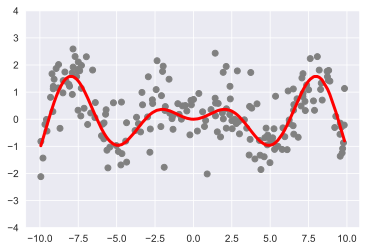

In [5]:
# plot true function and noisy data points
plt.plot(x_tr, y_tr, 'o', c = "gray")
plt.plot(x_tr, y_tr_true, c = "r", linewidth=3)
plt.ylim(-4, 4)

In [10]:
# fitting GP using gpr
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

kernel = ConstantKernel(1.0, constant_value_bounds=(1e-3, 1e3)) * RBF(length_scale=1e-1, 
                                                                      length_scale_bounds=(1e-2, 10))

gpr = GaussianProcessRegressor(
            kernel = kernel, normalize_y = True, alpha = 0.5, random_state = 202205
       ).fit(x_tr.reshape(-1, 1), y_tr)
gpr_mean_pred, gpr_std_pred = gpr.predict(x_te.reshape(-1, 1), return_std = True)

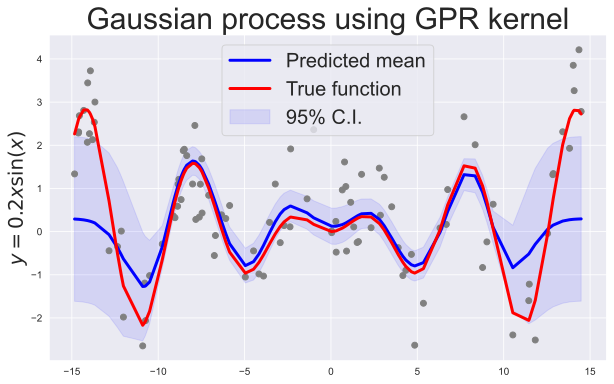

In [11]:
# making plots
plt.rcParams["figure.figsize"] = (10,6) # control plot size

plt.plot(x_te, y_te, 'o', c = "gray")
plt.plot(x_te, gpr_mean_pred, c = "b", linewidth = 3, label = 'Predicted mean') # plot predicted value
# plot confidence intervals
plt.fill_between(x_te, 
                 gpr_mean_pred - 1.96*gpr_std_pred, 
                 gpr_mean_pred + 1.96*gpr_std_pred, 
                 alpha = 0.1, color = "b", label = '95% C.I.')
plt.plot(x_te, y_te_true, c = "r", linewidth = 3, label = 'True function') # plot true function
plt.title("Gaussian process using GPR kernel", fontsize = 30)
plt.ylabel("$y = 0.2x\sin(x)$", fontsize = 20)
plt.legend(prop={'size': 20})